In [1]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [2]:
#BPSK Modulation
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*mu-1, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)

#BPSK demodulation        
def bpsk_demod(r_bb,L):
    x = np.real(r_bb) # I arm
    x = np.convolve(x,np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    return ak_hat

#Noise (AP to BD)
def noise(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    #r = s + n # received signal
    return n

#Noise (BD to AP)
def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal #AWGN channel
    return r

# In theoretical analyses and simulations, for AWGN, the channel gain ℎ is often considered as a complex Gaussian random variable 
# with unity magnitude (i.e.,|ℎ∣=1) and uniformly distributed phase between 0 and 2π. This assumption simplifies 
# the analysis and is a common model used in communication theory to characterize the effects of the channel.

### More Required Functions ###

In [3]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10(lamda_/(4*np.pi)) - 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL = Gt_dBi + Gr_dBi + K -10*n*math.log10(d/d0) - X  #PL(d) including antennas gains
    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 10 #distance between AP and BD
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 100 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 100 #distance between J and BD
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde 
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = 30 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power = (Pt_dBm*phi) + sigma**2
    P = combined_power*epsilon*G
    return P

### Number of steps/time slots ###

In [182]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 200 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot
EbN0dB = np.arange(start=-4,stop = 11,step = (11+4)/(nSteps)) # Eb/N0 range in dB for simulation
#BER = np.zeros(len(EbN0dB)) # for BER values for each Eb/N0


### System Parameters ###

In [183]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband

#### AP and Jammer Signal ####

In [184]:
x = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

### State Space, Action Space ###

In [185]:
#Define State, Action
# State {E_B}

#Jammer
K_J = np.random.randint(low=0, high = 2, size=(nSteps), dtype = int) #should be an array randomly changing between 0 and 1 of dimension = number of time steps
M = 5
P_J = K_J*(np.random.randint(low=1,high=M,size=(nSteps), dtype = int)) #Absence of jammer in the channel indicates no jamming power; jamming power = 1-4 W
#Distribute the time slot in CS+EH+BC
r = 0.25 #duty cycle 25%
τ = 1 #duration of each time slot is 1s
τ_sense = 0.15
τ_switch = np.array([0.1 if val == 1 else 0 for val in K_J])
τ_EH = τ - (r*τ) - (τ_sense + τ_switch)
P_T = 1 #np.random.randint(low=0, high = M)
ξ = 0.8 #energy harvesting efficiency
U_E = ξ*(P_J + P_T)*τ_EH #Unit Energy #Signal energy doesn't depend upon frequency
E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    
E_B = np.zeros(nSteps)

for j in range(nSteps):
    E_B [j] = E_B [j] - mu[j]*E_BC[j] - (1 - mu[j])*E_EH[j] + (1 - mu[j])*E_h[j] + 1*U_E[j]

state_space = np.array([E_B,K_J],dtype=object) #P_T doesn't contribute to channel selection decision #Channel/Frequency f_k has no effect on E_B or K_J
#define actions
#numeric action codes: 0 = channel 1, 1 = channel 2, 2 = channel 3, 3 = channel 4
action_space = np.array([0,1,2,3])

In [186]:
q_table = np.zeros((len(action_space), len(action_space)))
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Trainning Phase

In [187]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots
num_episodes = 100 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [188]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode)
P_R_AP = np.zeros(max_steps_per_episode)
P_N = np.zeros(max_steps_per_episode)
SNR = np.zeros(max_steps_per_episode)

# Q-learning algorithm
for episode in range(num_episodes):
    current_state = 0
    epochs += 1
    #rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state][:]) 
            #print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
            #print('Random Action: ',action)
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W
        M = 5 #Jammer power level upper limit
        P_J = np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4

        #reflection coefficient: s_bb = -1 for mu = 0=> non-reflecting state, s_bb = 1 for mu = 1=>reflecting state
        unwanted_signal = (P_J*JAP_ChannelGain(f_k)*abs(x_J)) + loopback_Channel()*abs(x) + abs(noise((x+x_J),EbN0dB[step],L))
        y_AP = ((s_bb[step]**2)*P_T*APBD_ChannelGain(f_k)*abs(x)) + ((s_bb[step]**2)*P_J*APBD_ChannelGain(f_k)*abs(x)*JBD_ChannelGain(f_k)*abs(x_J)) + \
        unwanted_signal
        P_R_AP[step] = sum(y_AP)/N
        P_N[step] = sum(unwanted_signal)/N
        SNR[step] =  P_R_AP[step]/P_N[step]
        #print('AP uses channel '+str(k)+' having frequency '+str(f_k))
        reward[step] = math.log(1+SNR[step])
        #next state
        new_state = action
        # Update Q-table for Q(s,a)
        q_table[current_state][action] = (1 - learning_rate) * q_table[current_state][action] + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state][:]))
        #print(q_table)
        # Transition to the next state
        current_state = new_state
        # Add new reward        
        rewards_current_step += reward[step]
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        all_iterations.append(iterations)
    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)



In [192]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[365.32712205 371.9444576  369.35124737 369.03021386]
 [371.48336478 371.83475757 372.26414185 371.26132558]
 [371.31494804 372.25450428 371.55314857 371.34307673]
 [369.08229433 372.02875414 369.35741511 368.79090008]]


## Plots ##

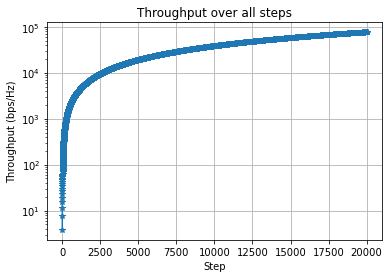

In [193]:
#Plotting rewards throughput over all steps

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_iterations,rewards_all_steps,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Step')
ax1.set_ylabel(r'Throughput (bps/Hz)')
ax1.set_title('Throughput over all steps')
plt.grid(True)

#plt.savefig('throughput_all_steps.png')

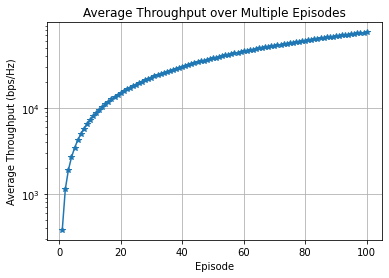

In [194]:
#Plotting average throughput over 100 episodes

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

plt.savefig('avg_throughput_all_episodes.png')

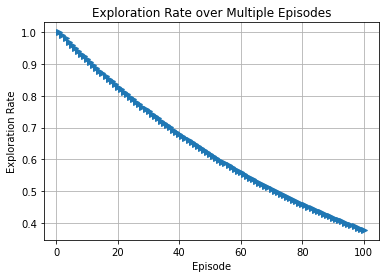

In [202]:
#Plotting exploration rate over 100 episodes

plt.plot(all_epochs,all_exploration_rate,'->') 
plt.xlabel(r'Episode')
plt.ylabel(r'Exploration Rate')
plt.title('Exploration Rate over Multiple Episodes')
plt.grid(True)

#plt.savefig('exploration_rate.png')